# Time Series Forecasting using Machine Learning models

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.regression import seasons, time_of_day, forecast_dates

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [184]:
building_nr = "all"
column_to_predict = "net_load_kWh"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building_nr": building_nr,
    "predicted_feature": column_to_predict,
    "resolution": "daily",
}

In [112]:
# Set write_date to True for logging to mlflow and SQL database
write_data = False

if write_data:
    
    # ## MLFLOW ##
    import mlflow
    from green_city.mlflow_config import get_mlflow_config

    flow_conf = get_mlflow_config()
    tracking_uri = flow_conf["TRACKING_URI"]
    mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
    mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    

    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))
    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)

In [185]:
# Load data
if building_nr == 'all':
    df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
else:
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [186]:
# Add additional columns for time
df['hour'] = df.index.hour.astype('category')
df['month'] = df.index.month.astype('category')
df['year'] = df.index.year.astype('category')
df['holiday'] = df['holiday'].astype('category')
df['workday'] = df['workday'].astype('category')

df['season'] = df['month'].apply(seasons).astype('category')
df['time_of_day'] = df['hour'].apply(time_of_day).astype('category')
df['day_of_week'] = df.index.day_of_week.astype('category')

# Creating lag variables
for i in range(24):
    df['net_load_kW_lag'+str(i+1)] = df['net_load_kW'].shift(i+1)
df['net_load_kW_lag168'] = df['net_load_kW'].shift(24*7)

# Exogenous variables for yearly, weekly and hourly seasonality
df['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
df['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
df['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
df['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
df['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
df['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
df['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
df['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
df['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
df['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
df['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 

# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

## Lasso Regression

In [ ]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Create the model
model_lasso = Lasso(alpha=0.01)

# Fit on training data
model_lasso.fit(X_train_scaled, y_train)

# Predict train and test data
y_pred_train = model_lasso.predict(X_train_scaled)
y_pred_test = model_lasso.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                        

In [ ]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['lasso'].iloc[0:24*4])

In [ ]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"alpha": np.linspace(0.05, 1.0, 96)}

# Do a randomized search
lasso_gscv = GridSearchCV(
                estimator=Lasso(random_state=RSEED),
                param_grid=param_grid,
                cv=tscv, verbose=2, n_jobs=-1)

# Fit train data
model_lasso = lasso_gscv.fit(X_train_scaled, y_train)

In [ ]:
print("Best model:", lasso_gscv.best_params_)

best_model = lasso_gscv.best_estimator_
best_params = lasso_gscv.best_params_

y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

df_train['lasso'] = y_pred_train
df_test['lasso'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso regression")

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Predict train and test data
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                               

In [ ]:
# # Using predicted weather to forecast net energy usage
# train_features = ['outdoor_temp', 'outdoor_hum', 
#                 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
#                 'hour', 'month', 'holiday', 'day_of_week',
#                 'net_load_kW_lag24', 'net_load_kW_lag168', 
#                 'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
#                 'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
#                 'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
# dummy_features = ['hour', 'month', 'holiday', 'workday']
# target = 'net_load_kW'

# # Using predicted weather to forecast net energy usage
# pred_features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
#                 'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
#                 'hour', 'month', 'holiday', 'day_of_week',
#                 'net_load_kW_lag24', 'net_load_kW_lag168', 
#                 'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
#                 'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
#                 'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']


# # Randomly chosen list of indices to forecast
# pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

# mae_list = []
# mse_list = []
# r2_list = []
# forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

# fig, ax = plt.subplots(4,2,figsize=(14,16))
# i = 1
# for index in pred_indices:
    
#     day = index2datetime(index)

#     # Train test splot
#     X_train = df[train_features].loc[:day]
#     y_train = df[[target]].loc[:day]
#     X_test = df[pred_features].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]
#     y_test = df[[target]].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]

#     model = Lasso(alpha=0.62, random_state=RSEED)

#     # rf = RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=7, 
#     #                         n_estimators=200, random_state=RSEED)

#     # Fit on training data
#     model.fit(X_train, y_train)

#     # Predict train and test data
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)
#     X_test['lasso'] = y_pred_test

#     # Print error metrics
#     mae = mean_absolute_error(y_test, y_pred_test)
#     mse = mean_squared_error(y_test, y_pred_test)
#     r2 = r2_score(y_test, y_pred_test)
#     print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
#     mae_list.append(mae)
#     mse_list.append(mse)
#     r2_list.append(r2)

#     # # Calculate and print error metrics
#     #_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso")       

#     # Plot actual vs predicted net energy usage for each of the chosen days
#     plt.subplot(4, 2, i)
#     y_test['net_load_kW'].plot()
#     X_test['lasso'].plot()
#     plt.title(day)
#     i = i + 1

#     if write_data:
#         # Starting the MLFlow run
#         r = mlflow.start_run(run_name="random_forest")
#         print("run-uuid:", r.info.run_uuid)
#         for k, v in global_params.items():
#             mlflow.log_param(k, v)
#             mlflow.log_param("model", "random_forest")
#             mlflow.log_param("datetime", day)
#             mlflow.log_param("feature", "net_load_kW")
#             mlflow.log_metric("mse", mse)
#             mlflow.log_metric("mae", mae)
#             mlflow.log_metric("r2_score", r2)
#         mlflow.end_run()

#         # DataFrame for writing to SQL database
#         day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
#         day_forecast['prediction'] = y_pred_test
#         day_forecast['run_id'] = r.info.run_uuid
#         day_forecast['id'] = np.arange(index+1,index+25)
#         forecasts = pd.concat([forecasts, day_forecast], axis=0)

# # Write to SQL DB
# if write_data:
#     forecasts = forecasts.set_index('id')
#     forecasts.to_sql("forecast", con=db, if_exists="append")

# print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")

## Random forest regression

We first train the model based on the measured weather data. We then use the trained model to forecast the net energy usage based on the 24h predicted weather data.

### Random forest regression with 24h lagged values and Fourier terms for daily, weekly and yearly seasonality

In [187]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'month', 'hour', 'holiday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['month', 'hour', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Create the model
#rf = RandomForestRegressor(random_state=RSEED)
rf = RandomForestRegressor(max_depth=10, min_samples_leaf=50, 
                            min_samples_split=5, n_estimators=150, random_state=RSEED)


# Fit on training data
rf.fit(X_train, y_train)

# Predict train and test data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
df_test['random_forest'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")                                                        

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.968
R2 (test) : 0.912
MAE (test): 30.531
MSE (test): 2145.877
RMSE(test): 46.324


In [188]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict 
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

# forecasts = df_test[['net_load_kW','random_forest','outdoor_temp','outdoor_hum']]
# forecasts["datetime"] = forecasts.index
# filename = '../data/models/random_forest_building_'+str(building_nr)+'.pkl'
# forecasts.to_pickle(filename)

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.958
R2 (test) : 0.903
MAE (test): 32.302
MSE (test): 2353.39
RMSE(test): 48.512


<AxesSubplot:>

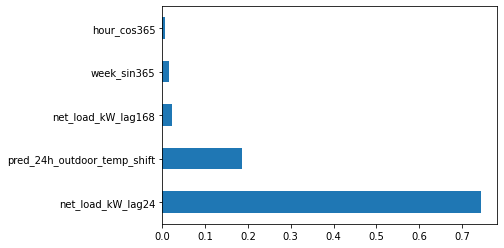

In [106]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

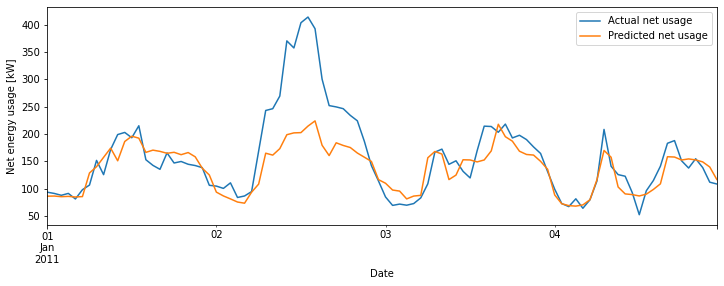

In [107]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['random_forest'].iloc[0:24*4])

### Run random search with cross validation to narrow down optimal hyperparameters

In [ ]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 9],
                "min_samples_leaf": [50, 100],
                "max_depth": [6, 7, 8, 9],
                "n_estimators": [100, 150, 200]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, scoring='r2', verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

In [ ]:
print("Best model:", rf_search.best_params_)

rf_model = rf_search.best_estimator_
rf_params = rf_search.best_params_

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

### Grid search to find the optimal hyperparameters

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

estimator = RandomForestRegressor(random_state=RSEED)

param_grid = {"min_samples_split": [5, 6, 7],
                "max_depth": [8, 9, 10],
                "min_samples_leaf": [50],
                "n_estimators": [100, 150, 200]
            }

gsc = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")                                                                                                                

In [ ]:
# Using predicted weather to forecast net energy usage
train_features = ['outdoor_temp', 'outdoor_hum', 
                'diffuse_solar_W_m2', 'direct_solar_W_m2', 
                'hour', 'month', 'holiday', 'day_of_week',
                'net_load_kW_lag24', 'net_load_kW_lag168', 
                'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
                'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
                'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Using predicted weather to forecast net energy usage
pred_features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
                'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
                'hour', 'month', 'holiday', 'day_of_week',
                'net_load_kW_lag24', 'net_load_kW_lag168', 
                'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
                'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
                'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']


# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

fig, ax = plt.subplots(4,2,figsize=(14,16))
i = 1
for index in pred_indices:
    
    day = index2datetime(index)

    # Train test splot
    X_train = df[train_features].loc[:day]
    y_train = df[[target]].loc[:day]
    X_test = df[pred_features].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]
    y_test = df[[target]].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]

    #rf = RandomForestRegressor(random_state=RSEED)
    rf = RandomForestRegressor(max_depth=10, min_samples_leaf=50, 
                                min_samples_split=5, n_estimators=150, random_state=RSEED)

    # Fit on training data
    rf.fit(X_train, y_train)

    # Predict train and test data
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    X_test['random_forest'] = y_pred_test

    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    # Calculate and print error metrics
    #_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")       

    # Plot actual vs predicted net energy usage for each of the chosen days
    plt.subplot(4, 2, i)
    y_test['net_load_kW'].plot()
    X_test['random_forest'].plot()
    plt.title(day)
    i = i + 1

    if write_data:
        # Starting the MLFlow run
        r = mlflow.start_run(run_name="random_forest")
        print("run-uuid:", r.info.run_uuid)
        for k, v in global_params.items():
            mlflow.log_param(k, v)
            mlflow.log_param("model", "random_forest")
            mlflow.log_param("datetime", day)
            mlflow.log_param("feature", "net_load_kW")
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2_score", r2)
        mlflow.end_run()

        # DataFrame for writing to SQL database
        day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
        day_forecast['prediction'] = y_pred_test
        day_forecast['run_id'] = r.info.run_uuid
        day_forecast['id'] = np.arange(index+1,index+25)
        forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
    forecasts = forecasts.set_index('id')
    forecasts.to_sql("forecast", con=db, if_exists="append")

print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")

## XGBoost

### XGBoost including weather

In [189]:
# Include weather features 
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'month', 'hour', 'holiday', 'day_of_week',
            'net_load_kW_lag24', 'net_load_kW_lag168',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['month', 'hour', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Fit training data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=RSEED)
xg_reg.fit(X_train, y_train)  

# Predict on train and test data
y_pred_train = xg_reg.predict(X_train)
y_pred_test = xg_reg.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.994
R2 (test) : 0.923
MAE (test): 26.987
MSE (test): 1866.651
RMSE(test): 43.205


In [190]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 10],
                "min_samples_leaf": [50, 80, 100],
                "max_depth": [5, 6, 7, 8, 9],
                "n_estimators": [100, 150, 200, 250, 300]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=7, n_estimators=150; total time=   4.3s
[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=10, n_estimators=100; total time=   6.0s
[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=7, n_estimators=150; total time=   3.7s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=7, n_estimators=300; total time=   8.8s
[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=10, n_estimators=100; total time=   9.1s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=7, n_estimators=150; total time=   9.4s
[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=7, n_estimators=150; total time=   7.8s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=7, n_estimators=150; total time=  15.6s
[CV] END max_depth=7, mi

In [191]:
# Grid search cross validation
gsc = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid={"learning_rate": [0.01, 0.05, 0.10, 0.15],
                    "max_depth": [ 4, 5, 6, 7 ],
                    "n_estimators": [100, 150, 200],
                    },
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   2.9s


KeyboardInterrupt: 

In [ ]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on train and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

In [ ]:
plot_ts(df_train['net_load_kW'], df_train['xgboost'])

In [ ]:
plot_ts(df_test['net_load_kW'], df_test['xgboost'])

In [ ]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['xgboost'].iloc[0:24*4])

### XGBoost using weather predictions

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [ ]:
# Forecast using 24h weather predictions 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")